# 生成式对抗网络

In [1]:
# GAN生成器网络
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim, ))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = keras.models.Model(generator_input, x) 
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [2]:
# GAN 判别器
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x) 
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x) 
x = layers.Dense(1, activation='sigmoid')(x) 
discriminator = keras.models.Model(discriminator_input, x) 
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008,
                                                   clipvalue=1.0, 
                                                   decay=1e-8) 
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

In [3]:
# 对抗网络
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,)) 
gan_output = discriminator(generator(gan_input)) 
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [5]:
# 实现 GAN 的训练
import os
from keras.preprocessing import image
from keras.utils import array_to_img
from keras.datasets import cifar10


(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'D://ML/gan_images'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

1/1 [==============================] - 0s 456ms/step
discriminator loss at step 0: 9.619386672973633
adversarial loss at step 0: 14.863489151000977
1/1 [==============================] - 1s 518ms/step
discriminator loss at step 100: 0.5883208513259888
adversarial loss at step 100: 0.905834972858429
1/1 [==============================] - 1s 503ms/step


1/1 [==============================] - 0s 500ms/step
discriminator loss at step 200: 0.7114610075950623
adversarial loss at step 200: 0.7331564426422119
1/1 [==============================] - 1s 546ms/step
discriminator loss at step 300: 0.6958544254302979
adversarial loss at step 300: 0.7512584924697876


1/1 [==============================] - 0s 496ms/step
discriminator loss at step 400: 0.6997163891792297
adversarial loss at step 400: 0.7564913630485535
1/1 [==============================] - 1s 511ms/step


1/1 [==============================] - 1s 522ms/step
discriminator loss at step 500: 0.6965583562850952
adversarial loss at step 500: 0.7480341196060181
1/1 [==============================] - 1s 895ms/step
discriminator loss at step 600: 0.6838140487670898
adversarial loss at step 600: 0.7778149247169495
1/1 [==============================] - 1s 878ms/step


1/1 [==============================] - 1s 527ms/step
discriminator loss at step 700: 0.6952228546142578
adversarial loss at step 700: 0.7365163564682007
1/1 [==============================] - 1s 824ms/step


1/1 [==============================] - 1s 509ms/step
discriminator loss at step 800: 0.7036265134811401
adversarial loss at step 800: 0.7420288920402527
1/1 [==============================] - 1s 860ms/step
discriminator loss at step 900: 0.7067152857780457
adversarial loss at step 900: 0.7324639558792114
1/1 [==============================] - 1s 817ms/step


1/1 [==============================] - 1s 893ms/step
discriminator loss at step 1000: 0.6949774622917175
adversarial loss at step 1000: 0.7296543717384338
1/1 [==============================] - 1s 511ms/step


1/1 [==============================] - 1s 540ms/step
discriminator loss at step 1100: 0.7033554315567017
adversarial loss at step 1100: 0.8127195239067078
1/1 [==============================] - 1s 869ms/step
discriminator loss at step 1200: 0.6845499873161316
adversarial loss at step 1200: 0.7808111310005188
1/1 [==============================] - 1s 842ms/step


1/1 [==============================] - 1s 878ms/step
discriminator loss at step 1300: 0.6867606043815613
adversarial loss at step 1300: 0.7764455080032349
1/1 [==============================] - 1s 529ms/step


1/1 [==============================] - 1s 506ms/step
discriminator loss at step 1400: 0.6844836473464966
adversarial loss at step 1400: 0.7894664406776428
1/1 [==============================] - 0s 495ms/step
discriminator loss at step 1500: 0.6856547594070435
adversarial loss at step 1500: 0.7311040759086609
1/1 [==============================] - 1s 549ms/step


1/1 [==============================] - 0s 481ms/step
discriminator loss at step 1600: 0.6964942812919617
adversarial loss at step 1600: 0.7548985481262207
1/1 [==============================] - 0s 484ms/step


1/1 [==============================] - 0s 492ms/step
discriminator loss at step 1700: 0.714083194732666
adversarial loss at step 1700: 0.744269073009491
1/1 [==============================] - 0s 486ms/step
discriminator loss at step 1800: 0.6933053731918335
adversarial loss at step 1800: 0.769055187702179
1/1 [==============================] - 0s 492ms/step


1/1 [==============================] - 1s 555ms/step
discriminator loss at step 1900: 0.7028743028640747
adversarial loss at step 1900: 0.7769589424133301
1/1 [==============================] - 1s 620ms/step


1/1 [==============================] - 1s 613ms/step
discriminator loss at step 2000: 0.6838172674179077
adversarial loss at step 2000: 0.6834640502929688
1/1 [==============================] - 1s 610ms/step
discriminator loss at step 2100: 0.6887714862823486
adversarial loss at step 2100: 0.741129457950592
1/1 [==============================] - 1s 581ms/step


1/1 [==============================] - 1s 542ms/step
discriminator loss at step 2200: 0.7085115313529968
adversarial loss at step 2200: 0.7301589250564575
1/1 [==============================] - 1s 545ms/step


1/1 [==============================] - 1s 537ms/step
discriminator loss at step 2300: 0.6885469555854797
adversarial loss at step 2300: 0.7758494019508362
1/1 [==============================] - 1s 540ms/step
discriminator loss at step 2400: 0.6960152387619019
adversarial loss at step 2400: 0.74271559715271
1/1 [==============================] - 1s 519ms/step


1/1 [==============================] - 1s 513ms/step
discriminator loss at step 2500: 0.6840061545372009
adversarial loss at step 2500: 0.7258889079093933
1/1 [==============================] - 1s 506ms/step


1/1 [==============================] - 1s 510ms/step
discriminator loss at step 2600: 0.6978633999824524
adversarial loss at step 2600: 0.9017431139945984
1/1 [==============================] - 1s 503ms/step
discriminator loss at step 2700: 0.6907106041908264
adversarial loss at step 2700: 0.7440816164016724
1/1 [==============================] - 1s 505ms/step


1/1 [==============================] - 1s 501ms/step
discriminator loss at step 2800: 0.6979368329048157
adversarial loss at step 2800: 0.7771352529525757
1/1 [==============================] - 0s 495ms/step


1/1 [==============================] - 1s 500ms/step
discriminator loss at step 2900: 0.6964845657348633
adversarial loss at step 2900: 0.7641195058822632
1/1 [==============================] - 1s 542ms/step
discriminator loss at step 3000: 0.8978596925735474
adversarial loss at step 3000: 0.7030357718467712
1/1 [==============================] - 1s 563ms/step


1/1 [==============================] - 1s 516ms/step
discriminator loss at step 3100: 0.6893938183784485
adversarial loss at step 3100: 0.7872324585914612
1/1 [==============================] - 0s 500ms/step


1/1 [==============================] - 1s 516ms/step
discriminator loss at step 3200: 0.699276864528656
adversarial loss at step 3200: 0.7479974627494812
1/1 [==============================] - 0s 484ms/step
discriminator loss at step 3300: 0.6995809078216553
adversarial loss at step 3300: 0.7409696578979492
1/1 [==============================] - 0s 485ms/step


1/1 [==============================] - 0s 474ms/step
discriminator loss at step 3400: 0.6849028468132019
adversarial loss at step 3400: 0.7320142984390259
1/1 [==============================] - 0s 467ms/step


1/1 [==============================] - 1s 506ms/step
discriminator loss at step 3500: 0.693187952041626
adversarial loss at step 3500: 0.7687492370605469
1/1 [==============================] - 0s 469ms/step
discriminator loss at step 3600: 0.6707766056060791
adversarial loss at step 3600: 0.6594600677490234
1/1 [==============================] - 0s 484ms/step


1/1 [==============================] - 0s 478ms/step
discriminator loss at step 3700: 0.6815568804740906
adversarial loss at step 3700: 0.8209139108657837
1/1 [==============================] - 1s 550ms/step


1/1 [==============================] - 1s 536ms/step
discriminator loss at step 3800: 0.6999284625053406
adversarial loss at step 3800: 0.8070939779281616
1/1 [==============================] - 1s 518ms/step
discriminator loss at step 3900: 0.6835395097732544
adversarial loss at step 3900: 0.773128092288971
1/1 [==============================] - 1s 518ms/step


1/1 [==============================] - 0s 489ms/step
discriminator loss at step 4000: 0.6878030896186829
adversarial loss at step 4000: 0.7416380643844604
1/1 [==============================] - 1s 501ms/step


1/1 [==============================] - 0s 490ms/step
discriminator loss at step 4100: 0.7043508887290955
adversarial loss at step 4100: 0.7871021032333374
1/1 [==============================] - 0s 488ms/step
discriminator loss at step 4200: 0.6680423617362976
adversarial loss at step 4200: 2.826855182647705
1/1 [==============================] - 0s 487ms/step


1/1 [==============================] - 0s 469ms/step
discriminator loss at step 4300: 0.6871736645698547
adversarial loss at step 4300: 0.7617200613021851
1/1 [==============================] - 0s 492ms/step


1/1 [==============================] - 0s 500ms/step
discriminator loss at step 4400: 0.7198280692100525
adversarial loss at step 4400: 0.7480977177619934
1/1 [==============================] - 0s 487ms/step
discriminator loss at step 4500: 0.7926167249679565
adversarial loss at step 4500: 0.7814964652061462
1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 473ms/step
discriminator loss at step 4600: 0.6999128460884094
adversarial loss at step 4600: 0.712680459022522
1/1 [==============================] - 1s 565ms/step


KeyboardInterrupt: 

1/1 [==============================] - 0s 228ms/step


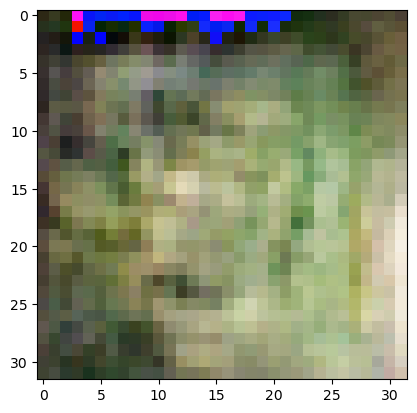

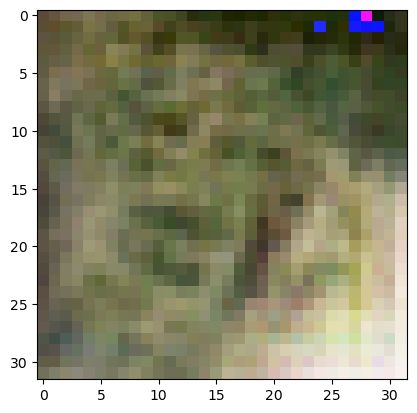

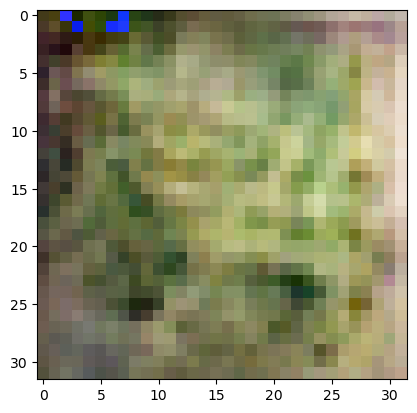

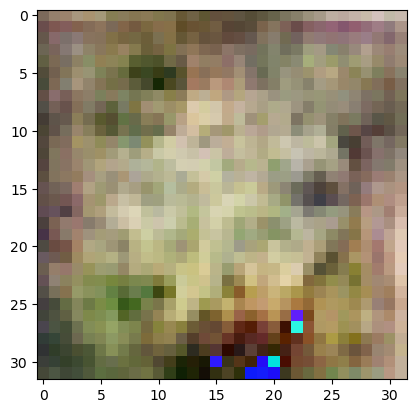

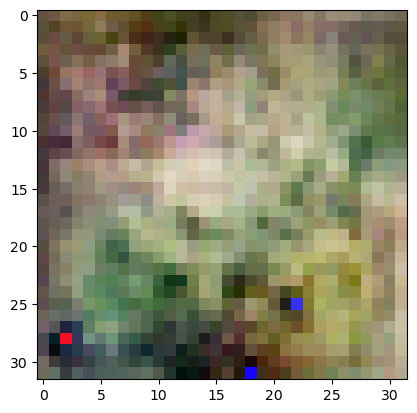

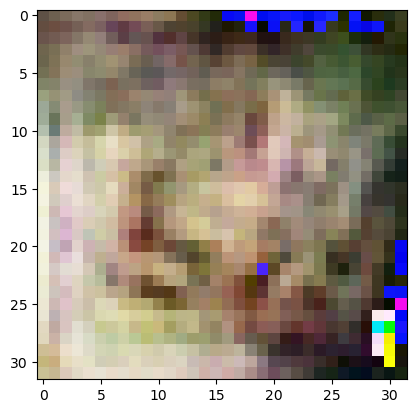

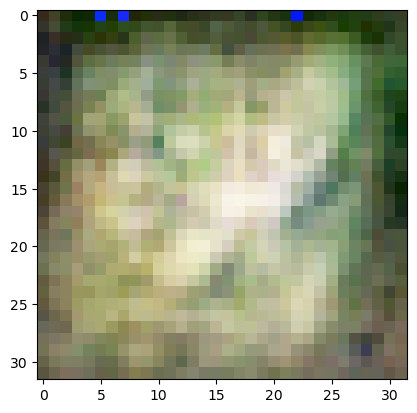

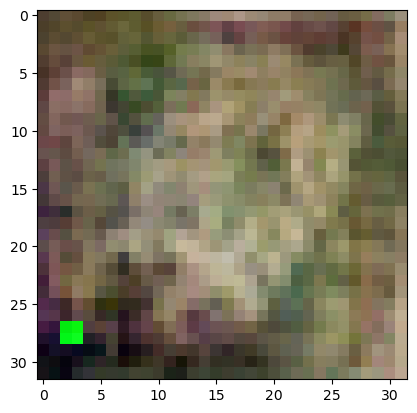

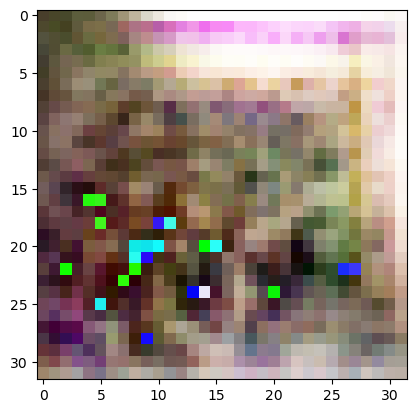

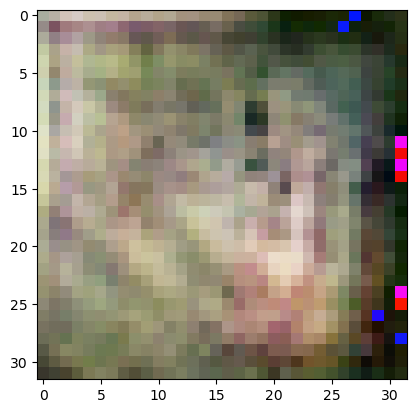

In [7]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()